In [4]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import cv2

from tensorflow.keras import models 
from tensorflow.keras import applications 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling3D, MaxPooling2D, Dropout, Flatten, LSTM, Dense, ConvLSTM2D, GRU, SimpleRNN
from tensorflow.keras import  callbacks
from tensorflow.keras import utils 

from collections import deque

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

In [5]:
import cv2 as cv
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]
width = 368
height = 368

inWidth = width
inHeight = height

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
thr = 0.2

def poseDetector(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()

    # Chỉnh kích thước của khung hình kết quả thành 128x128
    resized_frame = cv.resize(frame, (128, 128))



    # Chuẩn hóa khung hình
    normalized_frame = resized_frame / 255.0

    return normalized_frame

NotADirectoryError: [WinError 267] The directory name is invalid: 'Data/dataset.pkl'

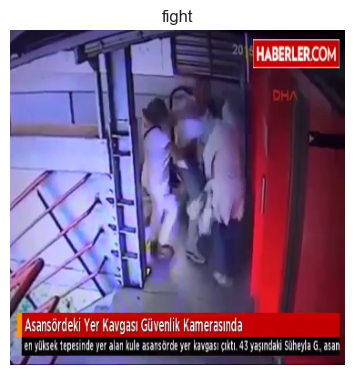

In [6]:
data_path = "Data"
# Tạo một hình ảnh Matplotlib và chỉ định kích thước của hình ảnh.
plt.figure(figsize=(20, 20))

# Lấy tên của tất cả các lớp/phân loại trong tập dữ liệu.
all_classes_names = os.listdir(data_path)
all_classes_names = all_classes_names[:-1]

# Sinh ra một danh sách gồm 2 giá trị ngẫu nhiên
random_range = random.sample(range(len(all_classes_names)), 3)

# Duyệt qua tất cả các giá trị ngẫu nhiên được sinh ra.
for counter, random_index in enumerate(random_range, 1):

    # Lấy tên lớp bằng cách sử dụng chỉ số ngẫu nhiên.
    selected_class_name = all_classes_names[random_index]

    # Lấy danh sách tất cả các tệp video có trong Thư mục Lớp được chọn ngẫu nhiên.
    video_files_names_list = os.listdir(f'Data/{selected_class_name}')
    video_files_names_list = video_files_names_list[:-1]
    # Chọn ngẫu nhiên một tệp video từ danh sách lấy được từ Thư mục Lớp được chọn ngẫu nhiên.
    selected_video_file_name = random.choice(video_files_names_list)

    # Khởi tạo một đối tượng VideoCapture để đọc từ Tệp video.
    video_reader = cv2.VideoCapture(f'Data/{selected_class_name}/{selected_video_file_name}')

    # Đọc khung hình đầu tiên từ tệp video.
    _, bgr_frame = video_reader.read()

    # Giải phóng đối tượng VideoCapture.
    video_reader.release()

    # Chuyển đổi không gian màu từ BGR sang RGB.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Chuyển đổi kích thước của khung hình thành 368x368
    resized_frame = cv2.resize(rgb_frame, (368, 368))

    # Hiển thị khung hình trên hình ảnh Matplotlib.
    plt.subplot(4, 4, counter)
    plt.imshow(resized_frame)
    plt.title(selected_class_name)
    plt.axis('off')

# Hiển thị tất cả các khung hình đã chọn.
plt.show()

In [7]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "Data"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["fight", "Trespassing","stroke"]

In [8]:
def frames_extraction(video_path):
    '''
    Hàm này sẽ trích xuất các khung hình cần thiết từ một video.
    Tham số:
        video_path: Đường dẫn của video trên ổ đĩa, các khung hình sẽ được trích xuất từ đó.
    Returns:
        frames_list: Một danh sách chứa các khung hình đã được thay đổi kích thước của video.
    '''
    # Khai báo một danh sách để lưu các khung hình video.
    frames_list = []

    # Đọc tệp Video sử dụng đối tượng VideoCapture.
    video_reader = cv2.VideoCapture(video_path)

    # Lấy tổng số khung hình trong video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Tính toán khoảng cách sau đó các khung hình sẽ được thêm vào danh sách.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Duyệt qua các Khung hình của Video.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Thiết lập vị trí khung hình hiện tại của video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Đọc khung hình từ video.
        success, frame = video_reader.read()

        # Kiểm tra nếu Khung hình Video không được đọc thành công thì thoát khỏi vòng lặp.
        if not success:
            break

        # Thay đổi kích thước Khung hình thành chiều cao và chiều rộng cố định.
        resized_frame = cv2.resize(frame, (368, 368))

        # Thêm khung hình vào danh sách khung hình
        frames_list.append(resized_frame)

    # Giải phóng đối tượng VideoCapture.
    video_reader.release()

    # Trả về danh sách các khung hình.
    return frames_list



In [9]:

def create_dataset(CLASSES_LIST, DATASET_DIR, SEQUENCE_LENGTH):
    '''
    Hàm này sẽ trích xuất dữ liệu của các lớp được chọn và tạo tập dữ liệu cần thiết.
    Returns:
        features:          Một danh sách chứa các điểm chính của video được trích xuất.
        labels:            Một danh sách chứa các chỉ mục của các lớp liên quan đến video.
        video_files_paths: Một danh sách chứa các đường dẫn của các video trên đĩa.
    '''

    # Khai báo danh sách trống để lưu trữ các điểm chính, chỉ mục và đường dẫn video.
    features = []
    labels = []
    video_files_paths = []

    # Duyệt qua tất cả các lớp được liệt kê trong danh sách lớp
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Hiển thị tên của lớp mà dữ liệu đang được trích xuất.
        print(f'Đang trích xuất dữ liệu của lớp: {class_name}')

        # Lấy danh sách các tệp video có trong thư mục tên lớp cụ thể.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Duyệt qua tất cả các tệp có trong danh sách tệp.
        for file_name in files_list:

            # Lấy đường dẫn video đầy đủ.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Trích xuất các khung hình của tệp video.
            frames = frames_extraction(video_file_path)

            # Kiểm tra nếu các khung hình đã trích xuất bằng với SEQUENCE_LENGTH được chỉ định ở trên.
            # Do đó, bỏ qua các video có số khung hình ít hơn SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Khởi tạo danh sách để lưu trữ các điểm chính của các khung hình được chọn trong video.
                keypoints_list = []

                # Duyệt qua các khung hình đã trích xuất
                for frame in frames:
                    # Trích xuất điểm chính từ khung hình đã chuẩn hóa
                    keypoints = poseDetector(frame)
                    # Thêm các điểm chính vào danh sách
                    keypoints_list.append(keypoints)

                # Thêm dữ liệu vào các danh sách tương ứng của chúng.
                features.append(keypoints_list)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Chuyển đổi các danh sách thành các mảng numpy
    features = np.asarray(features)
    labels = np.array(labels)

    # Trả về các điểm chính, chỉ mục lớp và đường dẫn tệp video.
    return features, labels, video_files_paths



In [10]:
# Create the dataset.
features, labels, video_files_paths = create_dataset(CLASSES_LIST,DATASET_DIR,SEQUENCE_LENGTH)


Đang trích xuất dữ liệu của lớp: fight
Đang trích xuất dữ liệu của lớp: Trespassing
Đang trích xuất dữ liệu của lớp: stroke


In [11]:

# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)
seed_constant = 42  # Define and assign a value to seed_constant for reproducibility
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

In [12]:
with open('Data/dataset.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
with open('Data/dataset.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [13]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128,128

def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = tf.keras.Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [14]:
from tensorflow.keras.layers import TimeDistributed, MaxPooling2D, Dropout
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

C:\Users\Gaming 3\PycharmProjects\load_model\.venv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 128, 128,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 32, 32, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 8, 8, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 256)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,603 (381.26 KB)

 Trainable params: 97,603 (381.26 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [15]:
# New model using LSTM
# Create an Instance of Early Stopping Callback.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = X_train, y = y_train, epochs = 20, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3984 - loss: 1.1293 - val_accuracy: 0.4815 - val_loss: 1.0602
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 866ms/step - accuracy: 0.4603 - loss: 1.0447 - val_accuracy: 0.4815 - val_loss: 1.0853
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 828ms/step - accuracy: 0.3908 - loss: 1.1010 - val_accuracy: 0.5000 - val_loss: 1.0891
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 801ms/step - accuracy: 0.4197 - loss: 1.0692 - val_accuracy: 0.4444 - val_loss: 1.0376
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 733ms/step - accuracy: 0.5338 - loss: 0.9659 - val_accuracy: 0.4444 - val_loss: 1.0458
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 789ms/step - accuracy: 0.5791 - loss: 0.8757 - val_accuracy: 0.4630 - val_loss: 1.1791
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 762ms/step - accuracy: 0.6357 - loss: 0.7924 - val_accuracy: 0.4630 - val_loss: 1.1951
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 819ms/step - accuracy: 0.7202 - loss: 0.7084 - val_accura

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


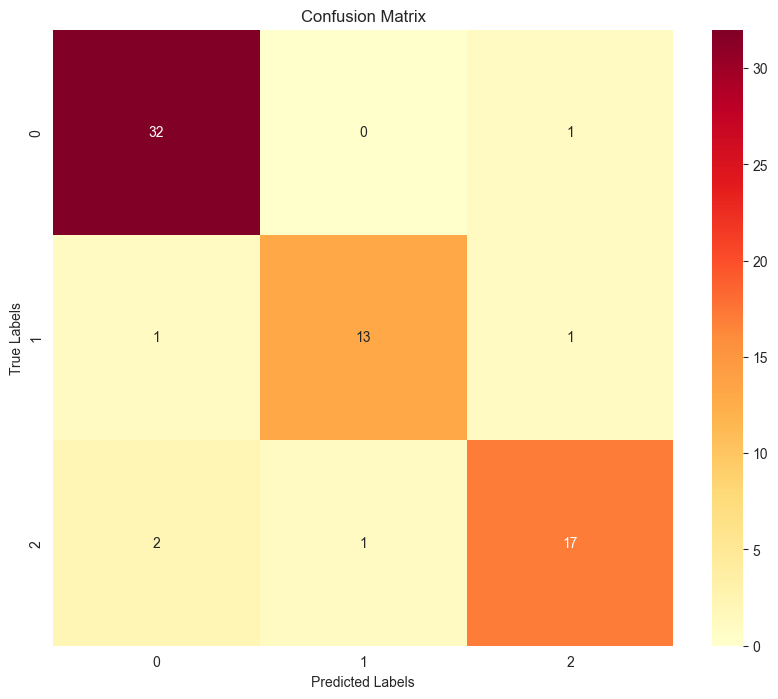

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        33
           1       0.93      0.87      0.90        15
           2       0.89      0.85      0.87        20

    accuracy                           0.91        68
   macro avg       0.91      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68



In [16]:
 # Predict the labels on the test set
y_pred = LRCN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="YlOrRd")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

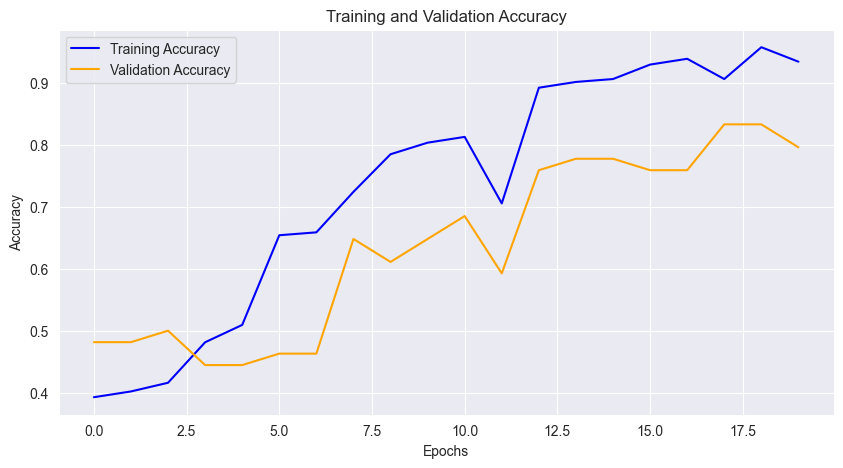

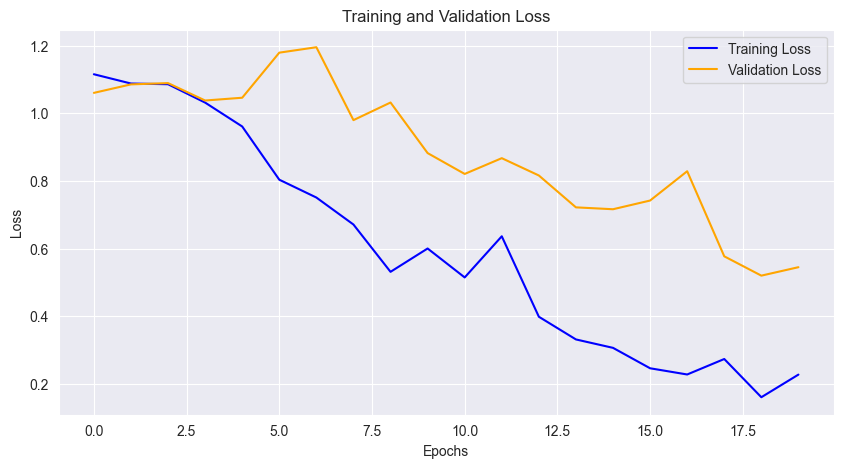

In [17]:
# Lấy thông tin về accuracy và loss từ quá trình huấn luyện
accuracy = LRCN_model_training_history.history['accuracy']
val_accuracy = LRCN_model_training_history.history['val_accuracy']
loss = LRCN_model_training_history.history['loss']
val_loss = LRCN_model_training_history.history['val_loss']

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Đánh giá mô hình
score = LRCN_model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.9246 - loss: 0.2472


In [19]:
# Lưu mô hình
LRCN_model.save("models/LRCN_with_LSTM(dropout0.25).h5")

In [20]:
new_model = tf.keras.models.load_model('models/LRCN_with_LSTM(dropout0.25).h5')

In [21]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 128, 128,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 32, 32, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 32, 32, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 8, 8, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 8, 8, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 256)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,605 (381.27 KB)

 Trainable params: 97,603 (381.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [22]:

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Use poseDetector function to preprocess the frame.
        processed_frame = poseDetector(resized_frame)

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        #normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(processed_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = new_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [23]:
input_video_file_path = "Data/fight/fi008.mp4"
from moviepy.editor import VideoFileClip
# Construct the output video path.
output_video_file_path = 'Output-SeqLen10.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Wri

Moviepy - Done !
Moviepy - video ready __temp__.mp4
